## Header
Please put your name and student ID number here as usual.

# YOLO V3 Object Detection

## 1. Introduction


As you learned in class, YOLO is a state-of-the-art, real-time object detection algorithm. In this notebook, we will apply the YOLO V3 algorithm to detect objects in images. We have provided a series of images that you can test the YOLO algorithm on and explain why it gave you the results that it did.

The questions in the last section are based on the paper "YOLOv3: An Incremental Improvement,"
Joseph Redmon, Ali Farhadi https://arxiv.org/abs/1804.02767.


There are named images that you can use to test the system. For the problems in the last sections, you will use the images with names that start from VOC to test system performance.

These images are located in the`./images/`folder. We encourage you to test the YOLO algorithm on your own images as well.

## 1.1 Acknowledgements
This code was created by Garima Nishad.

For detailed explanation you can refer to her blog here: https://towardsdatascience.com/you-only-look-once-yolo-implementing-yolo-in-less-than-30-lines-of-python-code-97fb9835bfd2?source=friends_link&sk=5c7234f716e38c8a7b6625ef20fa7811

This was inspired from CVND Udacity course

LinkedIn: https://www.linkedin.com/in/garima-nishad-9b8385134/



# Importing Resources

We will start by loading the required packages into Python. We will be using *OpenCV* to load our images, *matplotlib* to plot them, a`utils` module that contains some helper functions, and a modified version of *Darknet*. YOLO uses *Darknet53*, an open source, deep neural network framework written by the creators of YOLO. The version of *Darknet* used in this notebook has been modified to work in PyTorch 0.4 and has been simplified because we won't be doing any training. Instead, we will be using a set of pre-trained weights that were trained on the Common Objects in Context (COCO) database. For more information on *Darknet*, please visit <a href="https://pjreddie.com/darknet/">Darknet</a>.

# Setup Code
Before getting started we need to run some boilerplate code to set up our environment. You'll need to rerun this setup code each time you start the notebook.


### Google Colab Setup
We need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a 2024S folder and put all the files under A1 folder, then '2024S/A1'
# GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = '2024S/A1'
#/content/drive/MyDrive/Colab_EE428/Colab_S2024/A1
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab_EE428/Colab_S2024/A4_new'
GOOGLE_DRIVE_PATH = os.path.join('/content/drive', 'MyDrive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(GOOGLE_DRIVE_PATH)
print(os.listdir(GOOGLE_DRIVE_PATH))

/content/drive/MyDrive/Colab_EE428/Colab_S2024/A4_new
['YOLO.ipynb', 'images', '__pycache__', 'iti', 'cfg', '.git', 'LICENSE', 'README.md', 'darknet.py', 'utils.py', '.gitignore', 'YOLO.py', 'weights', 'data', 'out']


In [ ]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)



In [ ]:
pip install opencv-python

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

from utils import *
from darknet import Darknet

In [ ]:
# helper function(s) for logging and analysis of the architecture
import time, csv, os

log_data = []
CSV_PATH = os.path.join(GOOGLE_DRIVE_PATH, "out", "yolo_logs.csv")

def log_results(image_name, boxes, start_time, iou, nms, tag="default"):
    elapsed = (time.perf_counter() - start_time) * 1000.0
    confs = [float(b[5]) for b in boxes] if boxes else []
    row = {
        "tag": tag,  # e.g., "Q2_NMS", "Q3_IOU", "Q4_eval"
        "image": image_name,
        "iou_thresh": iou,
        "nms_thresh": nms,
        "num_boxes": len(boxes),
        "avg_conf": round(sum(confs)/len(confs), 4) if confs else 0.0,
        "min_conf": round(min(confs), 4) if confs else 0.0,
        "max_conf": round(max(confs), 4) if confs else 0.0,
        "time_ms": round(elapsed, 1),
    }
    print("\n[LOG]", row)
    append_row(row)


def save_logs_csv():
    if not log_data:
        print("No logs to save.")
        return
    out_dir = os.path.join(GOOGLE_DRIVE_PATH, "out")
    os.makedirs(out_dir, exist_ok=True)
    print(os.path.isdir(out_dir))
    csv_path = os.path.join(out_dir, "yolo_logs.csv")
    print(os.path.isfile(csv_path))
    with open(csv_path, "a", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=list(log_data[0].keys()))
        writer.writeheader()
        writer.writerows(log_data)
    print(f"Saved logs to {csv_path}")

def append_row(row: dict):
    out_dir = os.path.join(GOOGLE_DRIVE_PATH, "out")
    os.makedirs(out_dir, exist_ok=True)
    print(f"logging dir path exist: {os.path.isdir(out_dir)}")
    csv_path = os.path.join(out_dir, "yolo_logs.csv")
    print(f"logging file path exist: {os.path.isfile(csv_path)}")

    write_header = not os.path.exists(CSV_PATH)
    with open(CSV_PATH, "a", newline="") as f:
        w = csv.DictWriter(f, fieldnames=list(row.keys()))
        if write_header:
            w.writeheader()
        w.writerow(row)



# Setting Up The Neural Network

We will be using YOLOv3. We have already downloaded the `yolov3.cfg` file that contains the network architecture used by YOLOv3 and placed it in the `/cfg/` folder. Similarly, we have placed the `yolov3.weights` file that contains the pre-trained weights in the `/weights/` directory. Finally, the `/data/` directory, contains the `coco.names` file that has the list of the 80 object classes that the weights were trained to detect.

In the code below, we start by specifying the location of the files that contain the neural network architecture, the pre-trained weights, and the object classes.  We then use *Darknet* to setup the neural network using the network architecture specified in the `cfg_file`. We then use the`.load_weights()` method to load our set of pre-trained weights into the model. Finally, we use the `load_class_names()` function, from the `utils` module, to load the 80 object classes.

In [ ]:
# Set the location and name of the cfg file
cfg_file = os.path.join(GOOGLE_DRIVE_PATH, 'cfg/yolov3.cfg')
# Load the network architecture
m = Darknet(cfg_file)

# # Set the location and name of the pre-trained weights file
weight_file = os.path.join(GOOGLE_DRIVE_PATH, 'weights/yolov3.weights')

# Load the pre-trained weights
m.load_weights(weight_file)

# # Set the location and name of the COCO object classes file
namesfile = os.path.join(GOOGLE_DRIVE_PATH, 'data/coco.names')

print(cfg_file,weight_file,namesfile)
# # Load the COCO object classes
class_names = load_class_names(namesfile)


/content/drive/MyDrive/Colab_EE428/Colab_S2024/A4_new/cfg/yolov3.cfg /content/drive/MyDrive/Colab_EE428/Colab_S2024/A4_new/weights/yolov3.weights /content/drive/MyDrive/Colab_EE428/Colab_S2024/A4_new/data/coco.names


# The Darknet Backbone for object detection

Now that the neural network has been setup, we can see what it looks like. We can print the network using the `.print_network()` function.

In [ ]:
# Print the neural network used in YOLOv3
m.print_network()

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32
    1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64
    2 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32
    3 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64
    4 shortcut 1
    5 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128
    6 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64
    7 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128
    8 shortcut 5
    9 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64
   10 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128
   11 shortcut 8
   12 conv    256  3 x 3 / 2   104 x 104 x 128   ->    52 x  52 x 256
   13 conv    128  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x 128
   14 conv    256  3 x 3 / 1    52 x  52 x 128   ->    52 x  52 x 256
   15 shortcut 12
   16 conv    128  1 x 1

As we can see, the neural network used by YOLOv3 consists mainly of convolutional layers, with some shortcut connections and upsample layers. For a full description of this network please refer to the <a href="https://pjreddie.com/media/files/papers/YOLOv3.pdf">YOLOv3 Paper</a>.

# Loading and Resizing Our Images

In the code below, we load our images using OpenCV's `cv2.imread()` function. Since, this function loads images as BGR we will convert our images to RGB so we can display them with the correct colors.

As we can see in the previous cell, the input size of the first layer of the network is 416 x 416 x 3. Since images have different sizes, we have to resize our images to be compatible with the input size of the first layer in the network. In the code below, we resize our images using OpenCV's `cv2.resize()` function. We then plot the original and resized images.

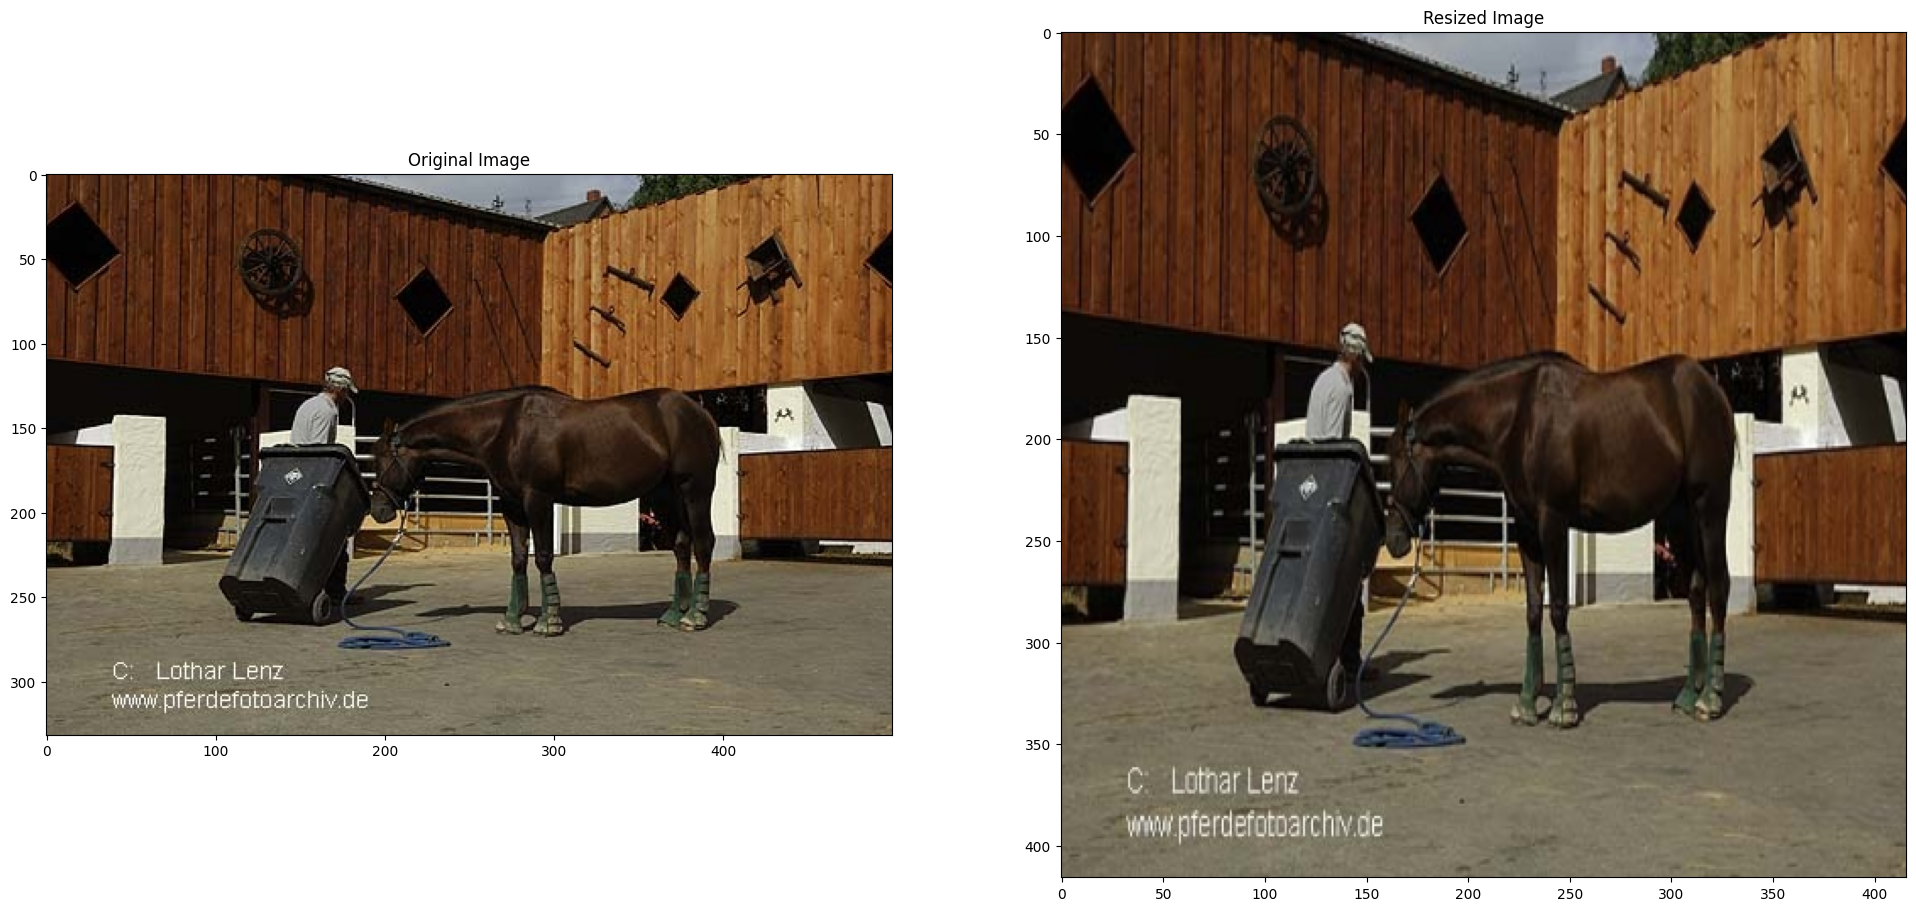

In [ ]:
# Set the default figure size
plt.rcParams['figure.figsize'] = [24.0, 14.0]

# Load the image
img = cv2.imread(os.path.join(GOOGLE_DRIVE_PATH,'images/VOC9954.jpg'))
# Convert the image to RGB
original_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# We resize the image to the input width and height of the first layer of the network.
resized_image = cv2.resize(original_image, (m.width, m.height))

# Display the images
plt.subplot(121)
plt.title('Original Image')
plt.imshow(original_image)
plt.subplot(122)
plt.title('Resized Image')
plt.imshow(resized_image)
plt.show()

# Setting the Non-Maximal Suppression Threshold

As you learned in the previous lessons, YOLO uses **Non-Maximal Suppression (NMS)** to only keep the best bounding box. The first step in NMS is to remove all the predicted bounding boxes that have a detection probability that is less than a given NMS threshold.  In the code below, we set this NMS threshold to `0.6`. This means that all predicted bounding boxes that have a detection probability less than 0.6 will be removed.

In [ ]:
# Set the NMS threshold
nms_thresh = 0.6

# Setting the Intersection Over Union Threshold

After removing all the predicted bounding boxes that have a low detection probability, the second step in NMS, is to select the bounding boxes with the highest detection probability and eliminate all the bounding boxes whose **Intersection Over Union (IOU)** value is higher than a given IOU threshold. In the code below, we set this IOU threshold to `0.4`. This means that all predicted bounding boxes that have an IOU value greater than 0.4 with respect to the best bounding boxes will be removed.

In the `utils` module you will find the `nms` function, that performs the second step of Non-Maximal Suppression, and the `boxes_iou` function that calculates the Intersection over Union of two given bounding boxes. You are encouraged to look at these functions to see how they work.

In [ ]:
# Set the IOU threshold
iou_thresh = 0.4

# Object Detection

Once the image has been loaded and resized, and you have chosen your parameters for `nms_thresh` and `iou_thresh`, we can use the YOLO algorithm to detect objects in the image. We detect the objects using the `detect_objects(m, resized_image, iou_thresh, nms_thresh)`function from the `utils` module. This function takes in the model `m` returned by *Darknet*, the resized image, and the NMS and IOU thresholds, and returns the bounding boxes of the objects found.

Each bounding box contains 7 parameters: the coordinates *(x, y)* of the center of the bounding box, the width *w* and height *h* of the bounding box, the confidence detection level, the object class probability, and the object class id. The `detect_objects()` function also prints out the time it took for the YOLO algorithm to detect the objects in the image and the number of objects detected. Since we are running the algorithm on a CPU it takes about 2 seconds to detect the objects in an image, however, if we were to use a GPU it would run much faster.

Once we have the bounding boxes of the objects found by YOLO, we can print the class of the objects found and their corresponding object class probability. To do this we use the `print_objects()` function in the `utils` module.

Finally, we use the `plot_boxes()` function to plot the bounding boxes and corresponding object class labels found by YOLO in our image. If you set the `plot_labels` flag to `False` you will display the bounding boxes with no labels. This makes it easier to view the bounding boxes if your `nms_thresh` is too low. The `plot_boxes()`function uses the same color to plot the bounding boxes of the same object class. However, if you want all bounding boxes to be the same color, you can use the `color` keyword to set the desired color. For example, if you want all the bounding boxes to be red you can use:

`plot_boxes(original_image, boxes, class_names, plot_labels = True, color = (1,0,0))`

You are encouraged to change the `iou_thresh` and `nms_thresh` parameters to see how they affect the YOLO detection algorithm. The default values of `iou_thresh = 0.4` and `nms_thresh = 0.6` work well to detect objects in different kinds of images. In the cell below, we have repeated some of the code used before in order to prevent you from scrolling up down when you want to change the `iou_thresh` and `nms_thresh`parameters or the image. Have Fun!

### 2.1 What Network Sees

The code in this section shows all the boxes found by the system when the thresholds are set to zero. This means that there is no filtering of the "objectness" probability. Note the number of boxes found and plotted and the number of nonsensical results. The confidence level given in the output is the confidence found by the object recognition system, NOT the "objectness" probability. The objectness probability is found in the fifth element of the bounding box vector shown below it.



It took 0.413 seconds to detect the objects in the image.

Number of Objects Detected: 2 

1. horse 1.000000 
[tensor(0.5920), tensor(0.6046), tensor(0.4133), tensor(0.4491), tensor(0.9997), tensor(1.0000), tensor(17)]
2. person 1.000000 
[tensor(0.3270), tensor(0.4181), tensor(0.0847), tensor(0.1457), tensor(0.9049), tensor(1.0000), tensor(0)]


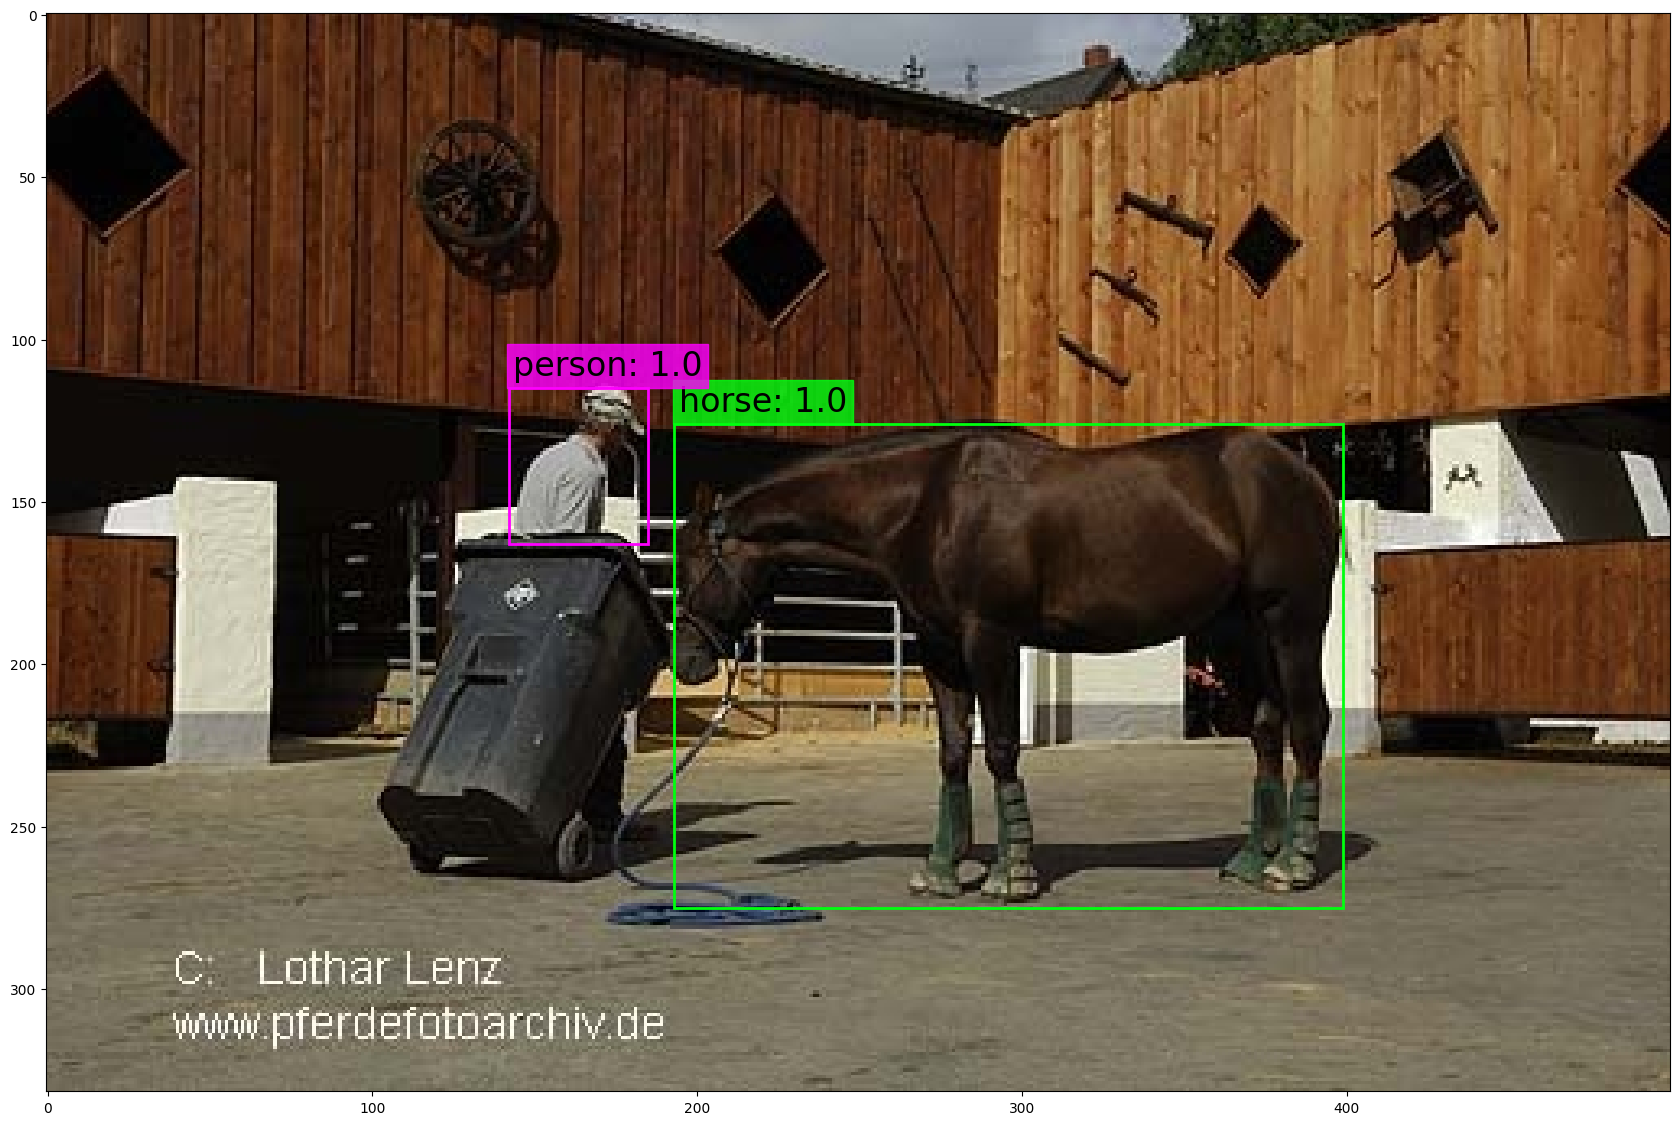

In [ ]:
# Set the default figure size
plt.rcParams['figure.figsize'] = [24.0, 14.0]

# Load the image
img_name = 'VOC9954.jpg'
img = cv2.imread(os.path.join(GOOGLE_DRIVE_PATH,'images/VOC9954.jpg'))

# Convert the image to RGB
original_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# We resize the image to the input width and height of the first layer of the network.
resized_image = cv2.resize(original_image, (m.width, m.height))

# Set the IOU threshold. Default value is 0.4
iou_thresh = 0.2

# Set the NMS threshold. Default value is 0.6
nms_thresh = 0.4

# Detect objects in the image
time_0=  time.perf_counter()
boxes_all = detect_objects(m, resized_image, iou_thresh, nms_thresh)
# log_results(img_name, boxes_all, time_0, iou_thresh, nms_thresh, tag="loose default run")

# Print the objects found and the confidence level and box information
for i in range(len(boxes_all)):
        box = boxes_all[i]

        if len(box) >= 7 and class_names:
            obj_conf = box[5]
            obj_coord = [box[1],box[2],box[3],box[4]]
            cls_conf = box[5]
            cls_id = box[6]

            print('%i. %s %f ' % (i + 1, class_names[cls_id], cls_conf))
            print(box)


#Plot the image with bounding boxes and corresponding object class labels
plot_boxes(original_image, boxes_all, class_names, plot_labels = True)





### 2.2 Effects of NMS and IoU Processing
This is the code that you will use to answer the questions in Section 3. You will need to experiment with differnt images, either from VOC or your own images to investigate the effects of the different thresholds.



It took 0.325 seconds to detect the objects in the image.

Number of Objects Detected: 2 


[LOG] {'tag': 'Q4_e', 'image': 'VOC9954.jpg', 'iou_thresh': 0.4, 'nms_thresh': 0.6, 'num_boxes': 2, 'avg_conf': 1.0, 'min_conf': 1.0, 'max_conf': 1.0, 'time_ms': 325.8}
logging dir path exist: True
logging file path exist: True
Objects Found and Confidence Level:

1. horse: 1.000000
[tensor(0.5920), tensor(0.6046), tensor(0.4133), tensor(0.4491), tensor(0.9997), tensor(1.0000), tensor(17)]
2. person: 1.000000
[tensor(0.3270), tensor(0.4181), tensor(0.0847), tensor(0.1457), tensor(0.9049), tensor(1.0000), tensor(0)]


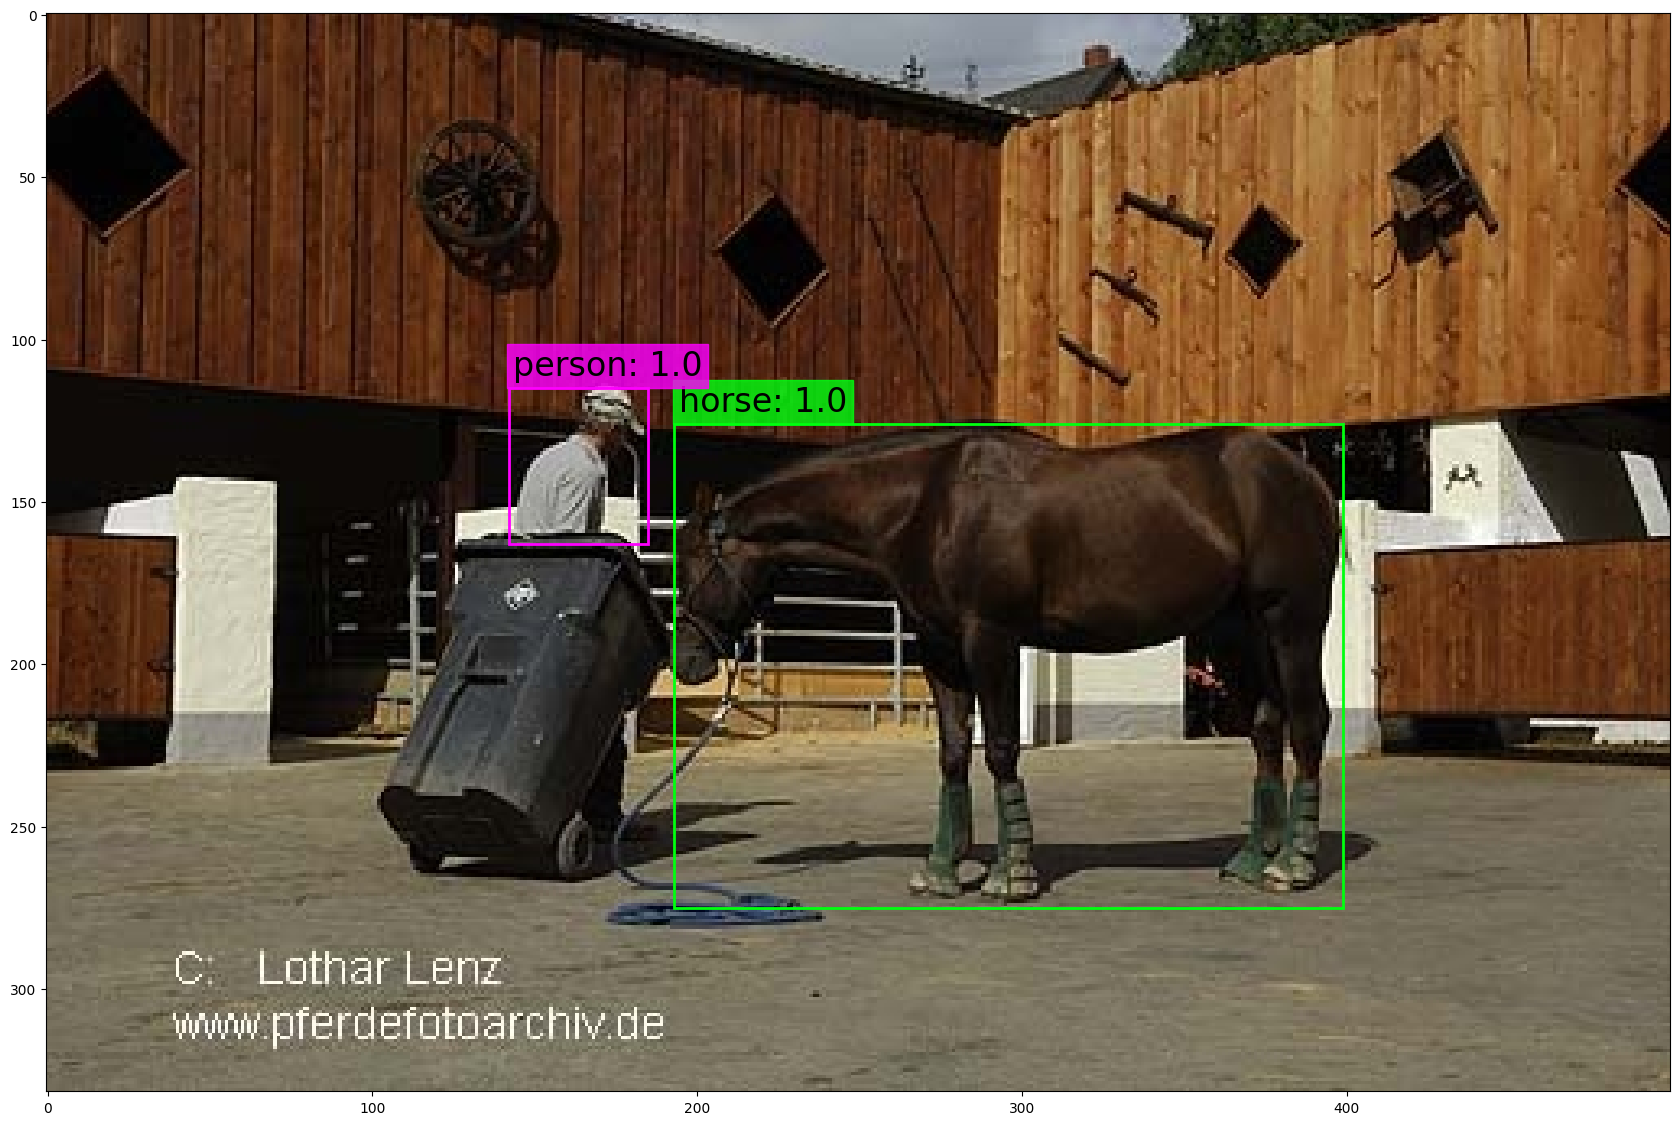

In [ ]:
# Set the default figure size
plt.rcParams['figure.figsize'] = [24.0, 14.0]

# Load the image
img = cv2.imread(os.path.join(GOOGLE_DRIVE_PATH,'images/VOC9954.jpg'))

# Convert the image to RGB
original_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# We resize the image to the input width and height of the first layer of the network.
resized_image = cv2.resize(original_image, (m.width, m.height))

# Set the IOU threshold. Default value is 0.4
iou_thresh = 0.4

# Set the NMS threshold. Default value is 0.6
nms_thresh = 0.6

# Detect objects in the image
img_name = 'VOC9954.jpg'  # or the VOC filename you use in this cell
t0 = time.perf_counter()
boxes = detect_objects(m, resized_image, iou_thresh, nms_thresh)
# log_results(img_name, boxes, t0, iou_thresh, nms_thresh, tag="Base")
log_results(img_name, boxes, t0, iou_thresh, nms_thresh, tag="Q4_e")

print_objects(boxes, class_names)
plot_boxes(original_image, boxes, class_names, plot_labels = True)


## 3.0 Homework Assignment

Before answering any questions, please be sure that you have read at least the YOLO V3 paper. The list of foundational YOLO papers is given below:
- You Only Look Once: Unified, Real-Time Object Detection, 2015.<a href="https://pjreddie.com/media/files/papers/yolo_1.pdf">YOLO Paper</a>
- YOLO9000: Better, Faster, Stronger, 2016.<a href="https://pjreddie.com/media/files/papers/YOLO9000.pdf">YOLO9000 Paper</a>
- YOLOv3: An Incremental Improvement, 2018.<a href="https://pjreddie.com/media/files/papers/YOLOv3.pdf">YOLOv3 Paper</a>


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

### Questions
1. YOLO V3 Questions
a. What is the output grid size for this model of YOLO?
b. How many bounding boxes prototypes are allowed for each grid-based anchor box?

2. NMS Threshold
a. Describe how the NMS algorithm works in your own words. Use an example from the images provided to illustrate your work.
b. What happens when the P(Objectness) (NMS Threshold) is set to zero?
NOTE: Don't try to run the system with NMS threshold of zero, it will be achingly slow and give many spurious detections.

3. IoU Threshold
a. Describe how the IoU threshold works to remove overlapping boxes in an image?
b. Using the images provided, show how changing the threshold adds and removes boxes.

4. Several images are provided in the image folder from the VOC data set. These images have some challenges such as object overlap and small objects. Run five images of your choice through the YOLO system with the same set of NMS and IoU thresholds and describe your results in terms of
a. Were the key objects found?
b. What was missed?
c. If there were multiples of the same object, were they all found correctly with appropriate bounding boxes?
d. Figure out how you can improve the system performance by changing the post-processing of the images.

# Q2
### Q2a
describe how the NMS algorithm works

use an example to illustrate

answer here


### Q2b
what happens when P(objectness)(nms thres) is set to 0?




In [ ]:
# data analysis of the results
import os
import pandas as pd
import seaborn


df = pd.read_csv(os.path.join(GOOGLE_DRIVE_PATH, 'out/yolo_logs.csv'))
df['conf_range'] = df['max_conf'] - df['min_conf']
df['conf_cv'] = df['conf_range'] / df['avg_conf']

df.to_csv(os.path.join(GOOGLE_DRIVE_PATH, 'out', 'analysis_log.csv'))
